# Load Packages

In [16]:
# this is just to know how much time will it take to run this entire ipython notebook 

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score


from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix
from collections import Counter
from collections import OrderedDict


drive_path = '/content/drive/MyDrive/poc/data/'


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Support Methods

In [18]:
# load the sps data to map the SPMASALE_TOTAL_STER to legacy_deal with sps_id
def load_sps_data(sps_file_path):
  sps_data = pd.read_csv(sps_file_path, names = ['orderNumber', 'SPMASALE_TOTAL_STER'],
                            sep=',', encoding='ISO-8859-1')
  sps_data.orderNumber = sps_data.orderNumber.apply(lambda s: s.replace('ï»¿',''))

  print(sps_data.shape)
  return sps_data


# load the legacy deals data of rightsline 
def load_legacy_deals_data(legacy_deals_file_path):

  legacy_deals = pd.read_csv(legacy_deals_file_path,
                            names = ['deal_id', 'sps_id', 'user_id', 'country', 'item_id', 'item_type'],
                            sep=',', encoding='ISO-8859-1')

  legacy_deals.deal_id = legacy_deals.deal_id.apply(lambda s: str(s).replace('ï»¿',''))
  legacy_deals.drop('country', axis=1, inplace=True)
  legacy_deals.drop_duplicates(inplace=True)

  legacy_deals.sps_id.fillna('NaN', inplace=True)

  print(legacy_deals.shape)
  return legacy_deals


# map the total_ster_amount_dict to legacy_deals data

def map_total_ster_amount_dict_to_legacy_deals_data(legacy_deals, sps_data):

  count_of_sps_ids = Counter(legacy_deals.sps_id.values)
  total_ster_amount_dict = {i[0]:i[1] for i in sps_data[['orderNumber', 'SPMASALE_TOTAL_STER']].values}

  total_ster_amount = {}
  sps_orderNumbers = sps_data.orderNumber.unique()

  for sps_id in tqdm(legacy_deals.sps_id.unique()):
      sps_ids = sps_id.split('|')
      amounts = []
      for id in sps_ids:
          if id in sps_orderNumbers:
              amounts.append(total_ster_amount_dict[id])
          else:
              amounts.append(np.NAN)
      total_ster_amount[sps_id]=np.sum(amounts)

  legacy_deals['total_ster_amount'] = legacy_deals.sps_id.apply(lambda id: total_ster_amount[id]/count_of_sps_ids[id])
      
  legacy_deals.drop(['sps_id'],axis=1,inplace=True)

  legacy_deals = legacy_deals[['deal_id', 'user_id', 'item_id', 'total_ster_amount', 'item_type']]
  legacy_deals.columns = ['deal_id', 'user_id', 'item_id', 'total_stering_amount', 'item_type']

  print(legacy_deals.shape)
  return legacy_deals

# load the other rightsline deasl except 'Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only'
def load_new_deals_data(new_deals_file_path):

  new_deals = pd.read_csv(new_deals_file_path, 
                          names = ['deal_id', 'user_id', 'item_id', 'country', 'total_stering_amount', 'item_type'],
                          
                          sep=',', encoding='ISO-8859-1')

  new_deals.deal_id = new_deals.deal_id.apply(lambda s: str(s).replace('ï»¿',''))

  new_deals.drop('country',axis=1,inplace=True)

  print(new_deals.shape)
  return new_deals

def create_users_total_purchase_count_and_items_total_purchase_count(all_deals_data):

  all_deals_data = all_deals_data.groupby(['user_id','item_id', 'item_type']).agg({'total_stering_amount': 'sum'}).rename(columns={'total_stering_amount': 'total_stering_amount_sum'}).reset_index()

  users_total_purchase_count = Counter(all_deals_data.user_id)
  items_total_purchase_count = Counter(all_deals_data.item_id)

  all_deals_data['users_total_purchase_count'] = all_deals_data.user_id.map(users_total_purchase_count)
  all_deals_data['items_total_purchase_count'] = all_deals_data.item_id.map(items_total_purchase_count)
  all_deals_data['class_label'] = 1

  print(all_deals_data.shape)
  return all_deals_data

#Create Dummy Data with Label 0

def create_dummy_data_with_label_0(all_deals_data, dummy_data_file_path):
  
  # load the saved "dummy_data" file for further processing 
  dummy_data = pd.read_pickle(dummy_data_file_path)

  real_data = list(zip(all_deals_data.user_id.values, all_deals_data.item_id.values))+list(dummy_data)

  uids = all_deals_data.user_id.unique()
  iids = all_deals_data.item_id.unique()

  while (len(dummy_data)<all_deals_data.shape[0]):
      uid = uids[random.randint(0, len(uids)-1)]
      iid = iids[random.randint(0, len(iids)-1)]
      if not (uid, iid) in real_data:
          dummy_data.add((uid,iid))
      else:
          continue
  
  return dummy_data

def create_dummy_data_with_0_label_dataFrmae(dummy_data, all_deals_data):

  item_type_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.item_id.values, all_deals_data.item_type.values)))}
  users_total_purchase_count_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.user_id.values, all_deals_data.users_total_purchase_count.values)))}
  items_total_purchase_count_mapping = {i[0]:i[1] for i in set(list(zip(all_deals_data.item_id.values, all_deals_data.items_total_purchase_count.values)))}

  dummy_data_with_0_label = pd.DataFrame(data=dummy_data, columns=['user_id','item_id'])
  dummy_data_with_0_label['item_type'] = all_deals_data.item_id.map(item_type_mapping)
  dummy_data_with_0_label['total_stering_amount_sum'] = 0.0
  dummy_data_with_0_label['users_total_purchase_count'] = all_deals_data.user_id.map(users_total_purchase_count_mapping)
  dummy_data_with_0_label['items_total_purchase_count'] = all_deals_data.item_id.map(items_total_purchase_count_mapping)
  dummy_data_with_0_label['class_label'] = 0

  print(dummy_data_with_0_label.shape)
  return dummy_data_with_0_label

# Content Mappings
def load_and_create_all_contents_mapped_to_series_data(all_catalog_file_path):
  
  all_catalog = pd.read_csv(all_catalog_file_path, encoding='ISO-8859-1', names=['series_id','series_temp','child_1','child_1_temp', 'child_2','child_2_temp', 'child_3','child_3_temp'])
  all_catalog.series_id = all_catalog.series_id.apply(lambda s: str(s).replace('ï»¿',''))
  print(all_catalog.shape)

  s1 = set(zip(all_catalog['child_1_temp'], all_catalog['child_1'], all_catalog['series_id']))
  s2 = set(zip(all_catalog['child_2_temp'], all_catalog['child_2'], all_catalog['series_id']))
  s3 = set(zip(all_catalog['child_3_temp'], all_catalog['child_3'], all_catalog['series_id']))

  s_all = set.union(s1,s2,s3)
  all_contents_mapped_to_series_data = pd.DataFrame(s_all,columns=['content_type', 'content_id', 'series_id'])
  all_contents_mapped_to_series_data = all_contents_mapped_to_series_data[~all_contents_mapped_to_series_data.content_type.isna()]
  all_contents_mapped_to_series_data[['content_id', 'series_id']]=all_contents_mapped_to_series_data[['content_id', 'series_id']].astype(int)
  print(all_contents_mapped_to_series_data.shape)
  
  all_contents_mapped_to_series_data.drop_duplicates(inplace=True)

  return all_contents_mapped_to_series_data

# Map the "concatenated_data" data with "version_creation_type_language"

def map_version_creation_type_language(version_creation_type_language_file_path, all_deals_with_series_id):
  
  version_creation_type_language = pd.read_csv(version_creation_type_language_file_path)

  all_deals_with_series_id = all_deals_with_series_id.merge(version_creation_type_language, left_on='item_id', right_on='_id')
  all_deals_with_series_id.drop('_id',axis=1,inplace=True)

  print(all_deals_with_series_id.shape)
  return all_deals_with_series_id, version_creation_type_language

# High level data of Series
# To create New/Update Series data using Collection
#https://stackoverflow.com/questions/51359783/python-flatten-multilevel-nested-json

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

def create_series_df(series_file_path):

  import json

  # Opening JSON file
  f = open(series_file_path)
    
  # returns JSON object as 
  # a dictionary
  data = json.load(f)

  out_data = []  
  # Iterating through the json
  # list
  for i in tqdm(data):
    out_data.append(flatten_json(i))
    
  # Closing file
  f.close()

  #create dataframe
  series_df = pd.DataFrame.from_dict(out_data)

  # create the formatted data
  print('Orginal shape')
  print(series_df.shape)
  print(' ')

  for i in range(223):
      firstName = series_df['ContentContributions_Data_{0}_Contributor_Data_FirstName'.format(i)]
      lastName = series_df['ContentContributions_Data_{0}_Contributor_Data_LastName'.format(i)]
      series_df['content_contributor_{0}'.format(i)]=firstName+' '+lastName
              
  print('After combining First & Last Names shape')
  print(series_df.shape)
  print(' ')

  ContentContributions_cols = [col for col in series_df.columns if 'ContentContributions' in col]
  series_df.drop(ContentContributions_cols,axis=1,inplace=True)

  use_columns = ['_id', 'LocalisedTerritory', 'SeriesNumber', 'SeriesType', 'CountryOfProduction', 'RightsArchive', 'CommissioningChannel_0', 'PlannedConfigurations', 'CoreCatalogue', 'Keywords_0', 'Keywords_1', 'Keywords_2', 'Keywords_3', 'Keywords_4', 'Keywords_5', 'OriginalLanguage', 'PremiumContent', 'ProductionDepartment_Name', 'Genres_0_Name', 'Genres_1_Name', 'SequenceNumber', 'Strand', 'VersionAnomaly', 'Resolutions_0', 'ThirdPartyProducers_0_Name', 'Synopses_0_Type', 'CopyrightYear', 'FinancialYear', 'TxSeason', 'TxYear', 'TxChannel', 'SeriesExtension', 'Keywords_6', 'Keywords_7', 'Synopses_1_Type', 'Synopses_2_Type', 'Resolutions', 'Genres_2_Name', 'Keywords_8', 'Keywords_9', 'Keywords_10', 'Keywords_11', 'ThirdPartyProducers_1_Name', 'Keywords_12', 'Keywords_13', 'Keywords_14', 'ThirdPartyProducers_2_Name', 'ThirdPartyProducers_3_Name', 'Keywords_15', 'Keywords_16', 'Keywords_17', 'Keywords_18', 'Keywords_19', 'Resolutions_1', 'Genres_3_Name', 'Keywords_20', 'Keywords_21', 'Keywords_22', 'Keywords_23', 'Keywords_24', 'Keywords_25', 'Keywords_26', 'Keywords_27', 'Keywords_28', 'Keywords_29', 'Keywords_30', 'Keywords_31', 'content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50', 'content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']

  rl_series_data = series_df[series_df.Status=='Approved'][use_columns]
  
  print('After dropping Non-Approved rows & ContentContributions columns')
  print(rl_series_data.shape)

  bool_feat = ['RightsArchive', 'CoreCatalogue', 'PremiumContent', 'VersionAnomaly']
  int_feat = ['_id', 'SequenceNumber', 'CopyrightYear', 'TxYear']
  use_columns = ['_id', 'LocalisedTerritory', 'SeriesNumber', 'SeriesType', 'CountryOfProduction', 'RightsArchive', 'CommissioningChannel_0', 'PlannedConfigurations', 'CoreCatalogue', 'Keywords_0', 'Keywords_1', 'Keywords_2', 'Keywords_3', 'Keywords_4', 'Keywords_5', 'OriginalLanguage', 'PremiumContent', 'ProductionDepartment_Name', 'Genres_0_Name', 'Genres_1_Name', 'SequenceNumber', 'Strand', 'VersionAnomaly', 'Resolutions_0', 'ThirdPartyProducers_0_Name', 'Synopses_0_Type', 'CopyrightYear', 'FinancialYear', 'TxSeason', 'TxYear', 'TxChannel', 'SeriesExtension', 'Keywords_6', 'Keywords_7', 'Synopses_1_Type', 'Synopses_2_Type', 'Resolutions', 'Genres_2_Name', 'Keywords_8', 'Keywords_9', 'Keywords_10', 'Keywords_11', 'ThirdPartyProducers_1_Name', 'Keywords_12', 'Keywords_13', 'Keywords_14', 'ThirdPartyProducers_2_Name', 'ThirdPartyProducers_3_Name', 'Keywords_15', 'Keywords_16', 'Keywords_17', 'Keywords_18', 'Keywords_19', 'Resolutions_1', 'Genres_3_Name', 'Keywords_20', 'Keywords_21', 'Keywords_22', 'Keywords_23', 'Keywords_24', 'Keywords_25', 'Keywords_26', 'Keywords_27', 'Keywords_28', 'Keywords_29', 'Keywords_30', 'Keywords_31', 'content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50']
  drop_features = ['content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']

  rl_series_data.drop(drop_features,axis=1,inplace=True)

  cat_feat = list(set(use_columns)-set(bool_feat)-set(int_feat))

  rl_series_data[cat_feat] = rl_series_data[cat_feat].astype(str)
  rl_series_data[int_feat] = rl_series_data[int_feat].astype(float)
  rl_series_data[bool_feat] = rl_series_data[bool_feat].astype(bool)
  rl_series_data._id = rl_series_data._id.astype(int)

  return rl_series_data

# Map content_contributors series data to "all_deals_with_series_id"

def map_content_contributors_series_data_to_all_deals_with_series_id(rl_series_data_file_path, all_deals_with_series_id):

  content_contributor_features = ['content_contributor_0', 'content_contributor_1', 'content_contributor_2', 'content_contributor_3', 'content_contributor_4', 'content_contributor_5', 'content_contributor_6', 'content_contributor_7', 'content_contributor_8', 'content_contributor_9', 'content_contributor_10', 'content_contributor_11', 'content_contributor_12', 'content_contributor_13', 'content_contributor_14', 'content_contributor_15', 'content_contributor_16', 'content_contributor_17', 'content_contributor_18', 'content_contributor_19', 'content_contributor_20', 'content_contributor_21', 'content_contributor_22', 'content_contributor_23', 'content_contributor_24', 'content_contributor_25', 'content_contributor_26', 'content_contributor_27', 'content_contributor_28', 'content_contributor_29', 'content_contributor_30', 'content_contributor_31', 'content_contributor_32', 'content_contributor_33', 'content_contributor_34', 'content_contributor_35', 'content_contributor_36', 'content_contributor_37', 'content_contributor_38', 'content_contributor_39', 'content_contributor_40', 'content_contributor_41', 'content_contributor_42', 'content_contributor_43', 'content_contributor_44', 'content_contributor_45', 'content_contributor_46', 'content_contributor_47', 'content_contributor_48', 'content_contributor_49', 'content_contributor_50']#, 'content_contributor_51', 'content_contributor_52', 'content_contributor_53', 'content_contributor_54', 'content_contributor_55', 'content_contributor_56', 'content_contributor_57', 'content_contributor_58', 'content_contributor_59', 'content_contributor_60', 'content_contributor_61', 'content_contributor_62', 'content_contributor_63', 'content_contributor_64', 'content_contributor_65', 'content_contributor_66', 'content_contributor_67', 'content_contributor_68', 'content_contributor_69', 'content_contributor_70', 'content_contributor_71', 'content_contributor_72', 'content_contributor_73', 'content_contributor_74', 'content_contributor_75', 'content_contributor_76', 'content_contributor_77', 'content_contributor_78', 'content_contributor_79', 'content_contributor_80', 'content_contributor_81', 'content_contributor_82', 'content_contributor_83', 'content_contributor_84', 'content_contributor_85', 'content_contributor_86', 'content_contributor_87', 'content_contributor_88', 'content_contributor_89', 'content_contributor_90', 'content_contributor_91', 'content_contributor_92', 'content_contributor_93', 'content_contributor_94', 'content_contributor_95', 'content_contributor_96', 'content_contributor_97', 'content_contributor_98', 'content_contributor_99', 'content_contributor_100', 'content_contributor_101', 'content_contributor_102', 'content_contributor_103', 'content_contributor_104', 'content_contributor_105', 'content_contributor_106', 'content_contributor_107', 'content_contributor_108', 'content_contributor_109', 'content_contributor_110', 'content_contributor_111', 'content_contributor_112', 'content_contributor_113', 'content_contributor_114', 'content_contributor_115', 'content_contributor_116', 'content_contributor_117', 'content_contributor_118', 'content_contributor_119', 'content_contributor_120', 'content_contributor_121', 'content_contributor_122', 'content_contributor_123', 'content_contributor_124', 'content_contributor_125', 'content_contributor_126', 'content_contributor_127', 'content_contributor_128', 'content_contributor_129', 'content_contributor_130', 'content_contributor_131', 'content_contributor_132', 'content_contributor_133', 'content_contributor_134', 'content_contributor_135', 'content_contributor_136', 'content_contributor_137', 'content_contributor_138', 'content_contributor_139', 'content_contributor_140', 'content_contributor_141', 'content_contributor_142', 'content_contributor_143', 'content_contributor_144', 'content_contributor_145', 'content_contributor_146', 'content_contributor_147', 'content_contributor_148', 'content_contributor_149', 'content_contributor_150', 'content_contributor_151', 'content_contributor_152', 'content_contributor_153', 'content_contributor_154', 'content_contributor_155', 'content_contributor_156', 'content_contributor_157', 'content_contributor_158', 'content_contributor_159', 'content_contributor_160', 'content_contributor_161', 'content_contributor_162', 'content_contributor_163', 'content_contributor_164', 'content_contributor_165', 'content_contributor_166', 'content_contributor_167', 'content_contributor_168', 'content_contributor_169', 'content_contributor_170', 'content_contributor_171', 'content_contributor_172', 'content_contributor_173', 'content_contributor_174', 'content_contributor_175', 'content_contributor_176', 'content_contributor_177', 'content_contributor_178', 'content_contributor_179', 'content_contributor_180', 'content_contributor_181', 'content_contributor_182', 'content_contributor_183', 'content_contributor_184', 'content_contributor_185', 'content_contributor_186', 'content_contributor_187', 'content_contributor_188', 'content_contributor_189', 'content_contributor_190', 'content_contributor_191', 'content_contributor_192', 'content_contributor_193', 'content_contributor_194', 'content_contributor_195', 'content_contributor_196', 'content_contributor_197', 'content_contributor_198', 'content_contributor_199', 'content_contributor_200', 'content_contributor_201', 'content_contributor_202', 'content_contributor_203', 'content_contributor_204', 'content_contributor_205', 'content_contributor_206', 'content_contributor_207', 'content_contributor_208', 'content_contributor_209', 'content_contributor_210', 'content_contributor_211', 'content_contributor_212', 'content_contributor_213', 'content_contributor_214', 'content_contributor_215', 'content_contributor_216', 'content_contributor_217', 'content_contributor_218', 'content_contributor_219', 'content_contributor_220', 'content_contributor_221', 'content_contributor_222']
  rl_content_contributors_data = pd.read_csv(rl_series_data_file_path, usecols=['_id', 'Genres_0_Name']+content_contributor_features) 
  print(rl_content_contributors_data.shape)

  for c in tqdm(content_contributor_features):
    rl_content_contributors_data[c] = rl_content_contributors_data['Genres_0_Name']+" :: "+rl_content_contributors_data[c]
  
  all_deals_with_content_contributors_data = all_deals_with_series_id[all_deals_with_series_id.class_label==1].merge(rl_content_contributors_data, left_on='series_id', right_on='_id')

  all_deals_with_content_contributors_data.drop(['Genres_0_Name', 'series_id', '_id', 'item_id', 'version_language', 'item_type', 'total_stering_amount_sum', 'users_total_purchase_count', 'items_total_purchase_count', 'class_label', 'version_creation_type'], axis=1, inplace=True)

  print(all_deals_with_content_contributors_data.shape)
  
  return all_deals_with_content_contributors_data, content_contributor_features

def create_user_contributor_interaction_sparse_matrix(all_deals_with_content_contributors_data, content_contributor_features):

  all_unique_contrib = all_deals_with_content_contributors_data[content_contributor_features].values.flatten()
  all_unique_contrib_dict = dict(pd.Series(all_unique_contrib).value_counts())

  all_users_contrib_data = {}

  for uid in tqdm(all_deals_with_content_contributors_data['user_id'].unique()):
    all_contrib = all_deals_with_content_contributors_data[all_deals_with_content_contributors_data.user_id==uid][content_contributor_features].values.flatten()
    all_users_contrib_data[uid] = dict(pd.Series(all_contrib).value_counts())

  user_contributor_interaction_sparse_matrix = {}

  user_contributor_interaction_sparse_matrix = csr_matrix((len(all_unique_contrib_dict), all_deals_with_content_contributors_data.user_id.nunique()), dtype=np.uint8)

  user_index_map = {user: idx for idx, user in enumerate(all_deals_with_content_contributors_data.user_id.unique())}
  contrib_index_map = {contrib: idx for idx, contrib in enumerate(all_unique_contrib_dict.keys())}

  for user, contrib_data in tqdm(all_users_contrib_data.items()):
    for contrib, count in contrib_data.items():
      row = contrib_index_map[contrib]
      col = user_index_map[user]
      user_contributor_interaction_sparse_matrix[row, col]=count
  
  return user_index_map, contrib_index_map, user_contributor_interaction_sparse_matrix

# High level Customer Data
def load_customer_data(cusotmer_data_path):

  customer_df = pd.read_csv(cusotmer_data_path, sep=',', encoding='ISO-8859-1')

  customer_df.proforma_customer.fillna(False, inplace=True)
  customer_df.fillna('NaN', inplace=True)

  customer_df.drop(['sap_cstomer_number','contact_name'],axis=1,inplace=True)

  print(customer_df.shape)
  return customer_df

# Map series data to SeriesCollections

def create_all_seriesCollections_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, seriesCollection_file_path, rl_series_data):

  all_seriesCollections_with_series_data = all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Series Collection'].merge(rl_series_data, left_on='series_id', right_on='_id')

  all_seriesCollections_with_series_data.drop(['content_type', 'series_id','_id'], axis=1, inplace=True)

  seriesCollection_title = pd.read_csv(seriesCollection_file_path, sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
  seriesCollection_title.dropna(inplace=True)
  seriesCollection_title.RecordID = seriesCollection_title.RecordID.astype(int)

  all_seriesCollections_with_series_data = all_seriesCollections_with_series_data.merge(version_creation_type_language, left_on='content_id', right_on='_id')
  all_seriesCollections_with_series_data.drop('_id',axis=1,inplace=True)
  all_seriesCollections_with_series_data = all_seriesCollections_with_series_data.merge(seriesCollection_title, left_on='content_id', right_on='RecordID')
  #all_seriesCollections_with_series_data.drop_duplicates(inplace=True)
  all_seriesCollections_with_series_data['title_without_version_creation_type'] = all_seriesCollections_with_series_data['Display Name'].apply(lambda x: re.sub('Broadcast|Co-producer|Edit|Language Dub|Worldwide]', '', str(x)))
  #all_seriesCollections_with_series_data['duplicate_count'] = all_seriesCollections_with_series_data['title_without_version_creation_type'].map(Counter(all_seriesCollections_with_series_data['title_without_version_creation_type']))
  all_seriesCollections_with_series_data.drop_duplicates(subset=['title_without_version_creation_type'],inplace=True)
  all_seriesCollections_with_series_data.drop(['RecordID', 'Display Name', 'title_without_version_creation_type'] ,axis=1,inplace=True)

  print(all_seriesCollections_with_series_data.shape)
  return all_seriesCollections_with_series_data

# Map series data to EpisodeVersions

def create_all_episodeVersions_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, episodeVersion_file_path, rl_series_data):

  all_episodeVersions_with_series_data = all_contents_mapped_to_series_data[all_contents_mapped_to_series_data.content_type=='Episode Version'].merge(rl_series_data, left_on='series_id', right_on='_id')

  all_episodeVersions_with_series_data.drop(['content_type', 'series_id','_id'], axis=1, inplace=True)

  all_episodeVersions_with_series_data.drop_duplicates(inplace=True)

  episodeVersion_title = pd.read_csv(episodeVersion_file_path, sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
  episodeVersion_title.dropna(inplace=True)
  episodeVersion_title.RecordID = episodeVersion_title.RecordID.astype(int)

  all_episodeVersions_with_series_data = all_episodeVersions_with_series_data.merge(version_creation_type_language, left_on='content_id', right_on='_id')
  all_episodeVersions_with_series_data.drop('_id',axis=1,inplace=True)
  all_episodeVersions_with_series_data = all_episodeVersions_with_series_data.merge(episodeVersion_title, left_on='content_id', right_on='RecordID')
  all_episodeVersions_with_series_data['title_without_version_creation_type'] = all_episodeVersions_with_series_data['Display Name'].apply(lambda x: re.sub('Broadcast|Co-producer|Edit|Language Dub|Worldwide]', '', str(x)))
  all_episodeVersions_with_series_data.drop_duplicates(subset=['title_without_version_creation_type'],inplace=True)
  all_episodeVersions_with_series_data.drop(['RecordID', 'Display Name', 'title_without_version_creation_type'],axis=1,inplace=True)

  print(all_episodeVersions_with_series_data.shape)
  return all_episodeVersions_with_series_data

# Handling Categorical Features

def vectorze_categoical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data):

  categoical_fetaures = [feat for feat in  train_data.columns if type(train_data[feat].iloc[0])==str]
  encode_objects_name = ["{0}_encode".format(col) for col in categoical_fetaures]

  for idx, feat in tqdm(enumerate(categoical_fetaures)):
      encode_objects_name[idx] = LabelEncoder()
      encode_objects_name[idx].fit(train_data[feat])

      #https://stackoverflow.com/questions/40321232/handling-unknown-values-for-label-encoding
      diff = [i for i in test_data[feat].unique() if i not in encode_objects_name[idx].classes_]
      if len(diff)>0:
          test_data[feat] = test_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
          encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
      train_data[feat]=encode_objects_name[idx].transform(train_data[feat])
      test_data[feat]=encode_objects_name[idx].transform(test_data[feat])

      if feat not in ['item_type', 'customer_group',
        'customer_city', 'customer_country', 'customer_active_salesorg',
        'customer_language', 'customer_risk_class']:
        sc_diff = [i for i in all_seriesCollections_with_series_data[feat].unique() if i not in encode_objects_name[idx].classes_]
        if len(sc_diff)>0:
            all_seriesCollections_with_series_data[feat] = all_seriesCollections_with_series_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
            encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
        all_seriesCollections_with_series_data[feat]=encode_objects_name[idx].transform(all_seriesCollections_with_series_data[feat])

        epv_diff = [i for i in all_episodeVersions_with_series_data[feat].unique() if i not in encode_objects_name[idx].classes_]
        if len(epv_diff)>0:
            all_episodeVersions_with_series_data[feat] = all_episodeVersions_with_series_data[feat].map(lambda s: '<unknown>' if s not in encode_objects_name[idx].classes_ else s) 
            encode_objects_name[idx].classes_ = np.append(encode_objects_name[idx].classes_, '<unknown>')
        all_episodeVersions_with_series_data[feat]=encode_objects_name[idx].transform(all_episodeVersions_with_series_data[feat])
    
  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data

# Handling Numerical Features
def impute_missing_and_standardize_numerical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data, all_deals_with_series_data):

  numerical_fetaures = [feat for feat in  all_deals_with_series_data.columns 
                        if (type(all_deals_with_series_data[feat].iloc[0])!=str) & (feat not in ['user_id','item_id','class_label'])]
  scaler_objects_name = ["{0}_scaler".format(col) for col in numerical_fetaures]

  mean_imp_objects_name = ["{0}_mean_imp".format(col) for col in numerical_fetaures]

  for idx, feat in enumerate(numerical_fetaures):

      #Imputation of missing values
      mean_imp_objects_name[idx] = SimpleImputer(missing_values=np.nan, strategy='mean')
      mean_imp_objects_name[idx].fit(np.array(train_data[feat].values).reshape(-1, 1))
      train_data[feat] = mean_imp_objects_name[idx].transform(np.array(train_data[feat].values).reshape(-1, 1))
      test_data[feat] = mean_imp_objects_name[idx].transform(np.array(test_data[feat].values).reshape(-1, 1))

      # Standardization of numerical values
      scaler_objects_name[idx] = StandardScaler()
      scaler_objects_name[idx].fit(np.array(train_data[feat].values).reshape(-1, 1))
      train_data[feat]=scaler_objects_name[idx].transform(np.array(train_data[feat].values).reshape(-1, 1) )
      test_data[feat]=scaler_objects_name[idx].transform(np.array(test_data[feat].values).reshape(-1, 1) )

      if feat not in ['items_total_purchase_count', 'total_stering_amount_sum', 'users_total_purchase_count']:
        all_episodeVersions_with_series_data[feat] = mean_imp_objects_name[idx].transform(np.array(all_episodeVersions_with_series_data[feat].values).reshape(-1, 1))
        all_episodeVersions_with_series_data[feat]=scaler_objects_name[idx].transform(np.array(all_episodeVersions_with_series_data[feat].values).reshape(-1, 1) )

        all_seriesCollections_with_series_data[feat] = mean_imp_objects_name[idx].transform(np.array(all_seriesCollections_with_series_data[feat].values).reshape(-1, 1))
        all_seriesCollections_with_series_data[feat]=scaler_objects_name[idx].transform(np.array(all_seriesCollections_with_series_data[feat].values).reshape(-1, 1) )
  
  return train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data
  
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

def get_dtypes(df):
  cols = df.dtypes.index
  col_dtypes = df.dtypes.values

  return {cols[idx]:str(col_dtypes[idx]) for idx in range(len(cols))}


#########################################################################
#########################################################################
#	Collaborative Filtering ##

# creating sparse matrix for seriesCollection & episodeVersion

def create_user_item_interaction_sparse_matrix(seriesCollection_to_title_map, episodeVersion_to_title_map, user_item_class_label_data):

  user_item_interaction_sparse_matrix = {}

  for content, data in {'Series Collection': seriesCollection_to_title_map, 'Episode Version': episodeVersion_to_title_map}.items():
    user_index_map = {user: idx for idx, user in enumerate(user_item_class_label_data.user_id.unique())}
    item_index_map = {item: idx for idx, item in enumerate(data.keys())}

    user_item_interaction_sparse_matrix[content] = csr_matrix((len(user_index_map), len(item_index_map)), dtype=np.uint8)

    content_ids = [id for id in user_item_class_label_data.item_id.unique() if id in data.keys()]

    content_data = user_item_class_label_data[user_item_class_label_data.item_id.isin(content_ids)]

    user_item_interacted_data = list(zip(content_data.user_id.values, content_data.item_id.values))

    for (user, item) in tqdm(user_item_interacted_data):
      row = user_index_map[user]
      col = item_index_map[item]
      user_item_interaction_sparse_matrix[content][row, col]=1

  return user_item_interaction_sparse_matrix

# Compute User-User Similarity matrix
# save user_contributor_interaction_sparse_matrix

def create_c_c_sim_sparse(user_genre_contributor_interaction_sparse_matrix):
  start = datetime.now()
  c_c_sim_sparse = cosine_similarity(X=user_genre_contributor_interaction_sparse_matrix, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  #sparse.save_npz(drive_path+"/production_data/c_c_sim_sparse.npz", c_c_sim_sparse)

  print("It's a ",c_c_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return c_c_sim_sparse
  
# Create recommendation function for new Item
def recommend_new_item_to_users(index_user_map, index_contrib_map, user_contributor_interaction_sparse_matrix, production_data, c_c_sim_sparse, contrib_index_map, top_users = 10):

  contrib_wise_user = {}

  for contrib, idx in contrib_index_map.items():
      contrib_wise_user[contrib] = [index_user_map[i] for i in (~user_contributor_interaction_sparse_matrix[idx,:].toarray()).argsort().flatten()]

  
  top_users_per_genre_and_contrib = {}
  top_simillar_users_per_genre_and_contrib = {}

  for key, val in tqdm(contrib_wise_user.items()):
      all_items = []
      similarities = c_c_sim_sparse[contrib_index_map[key]].toarray().ravel()
      top_10_contribs = [index_contrib_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
      for contrib in top_10_contribs:
        top_10_indices = contrib_wise_user[contrib][:top_users]
        all_items.extend(top_10_indices)

      d_sorted_by_value = OrderedDict(sorted(Counter(all_items).items(), key=lambda x: x[1], reverse=True))
      top_simillar_users_per_genre_and_contrib[key]=np.unique([i for i in production_data[production_data.user_id.isin(list(d_sorted_by_value.keys()))]['user_id'].values])[:top_users]
          
      top_users_per_genre_and_contrib[key]=contrib_wise_user[key][:top_users]
  
  return top_users_per_genre_and_contrib, top_simillar_users_per_genre_and_contrib

# SeriesCollection-SeriesCollection Similarity matrix

def create_sc_sc_sim_sparse(user_item_interaction_sparse_matrix):
  start = datetime.now()
  sc_sc_sim_sparse = cosine_similarity(X=user_item_interaction_sparse_matrix['Series Collection'].T, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  #sparse.save_npz(drive_path+"/intermittent_saved_files/sc_sc_sim_sparse.npz", sc_sc_sim_sparse)
  print("Done..")

  print("It's a ",sc_sc_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return sc_sc_sim_sparse

# EpisodeVersion-EpisodeVersion Similarity matrix
def create_epv_epv_sim_sparse(user_item_interaction_sparse_matrix):

  start = datetime.now()
  epv_epv_sim_sparse = cosine_similarity(X=user_item_interaction_sparse_matrix['Episode Version'].T, dense_output=False)
  print("Done..")
  # store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again.. ")
  #sparse.save_npz(drive_path+"/intermittent_saved_files/epv_epv_sim_sparse.npz", epv_epv_sim_sparse)
  print("Done..")
  print("It's a ",epv_epv_sim_sparse.shape," dimensional matrix")

  print(datetime.now() - start)
  return epv_epv_sim_sparse

# Create recommendation function for new User
def recommendatation_for_new_user(user_country_genre_category_wise_items, sc_sc_sim_sparse, sc_to_index_map, index_to_sc_map, epv_epv_sim_sparse, epv_to_index_map, index_to_epv_map, top_users=10):
  
  top_items_per_user_country_genre_category = {}
  top_simillar_items_per_user_country_genre_category = {}

  for country, content_data in tqdm(user_country_genre_category_wise_items.items()):
    top_items_per_user_country_genre_category[country] = {}
    top_simillar_items_per_user_country_genre_category[country] = {}
    for content, genre_data in content_data.items():
      top_items_per_user_country_genre_category[country][content] = {}
      top_simillar_items_per_user_country_genre_category[country][content] = {}
      for genre, item_data in genre_data.items():
        all_items = []
        for it_id in item_data[:top_users]:
            if content=='Series Collection':
              similarities = sc_sc_sim_sparse[sc_to_index_map[it_id]].toarray().ravel()
              top_10_indices = [index_to_sc_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
              all_items.extend(top_10_indices)
            elif content=='Episode Version':
              similarities = epv_epv_sim_sparse[epv_to_index_map[it_id]].toarray().ravel()
              top_10_indices = [index_to_epv_map[i] for i in similarities.argsort()[::-1][1:][:top_users]]
              all_items.extend(top_10_indices)
        d_sorted_by_value = OrderedDict(sorted(Counter(all_items).items(), key=lambda x: x[1], reverse=True))
        if content=='Series Collection':
          top_simillar_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in list(d_sorted_by_value.keys())])[:top_users]
          top_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in item_data])[:top_users]
        elif content=='Episode Version':
          top_simillar_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in list(d_sorted_by_value.keys())])[:top_users]
          top_items_per_user_country_genre_category[country][content][genre]=np.unique([item for item in item_data])[:top_users]
    
  return top_items_per_user_country_genre_category, top_simillar_items_per_user_country_genre_category


# Content-Based Data Pipleline

In [8]:
def content_based_data_pipleline():

  print('load the sps data to map the SPMASALE_TOTAL_STER to legacy_deal with sps_id')
  sps_file_path = drive_path+'/raw_data/sps_total_ster_amount_20-04-21.csv'
  sps_data = load_sps_data(sps_file_path)

  print('load the legacy deals data of rightsline') 
  legacy_deals_file_path = drive_path+'/raw_data/legacy_deal_details_20-05-21.csv'
  legacy_deals = load_legacy_deals_data(legacy_deals_file_path)

  print('map the total_ster_amount_dict to legacy_deals data')
  legacy_deals = map_total_ster_amount_dict_to_legacy_deals_data(legacy_deals, sps_data)

  print("load the other rightsline deasl except 'Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only'")
  new_deals_file_path = drive_path+'/raw_data/rl_other_deals_20-05-21.csv'
  new_deals = load_new_deals_data(new_deals_file_path)

  all_deals_data = pd.concat([new_deals, legacy_deals])
  print(all_deals_data.shape)

  print('save "all_deals_data" to csv file')
  all_deals_data_file_path = drive_path+'/intermittent_saved_files/all_deals_data_20-05-21.csv'
  all_deals_data.to_csv(all_deals_data_file_path,index=False)

  print('save "all_deals_data" to csv file')
  all_deals_data.to_csv(drive_path+'/intermittent_saved_files/all_deals_data_20-05-21.csv',index=False)

  print("Create new features 'users_total_purchase_count', 'items_total_purchase_count' & 'class_label=1'")
  all_deals_data = create_users_total_purchase_count_and_items_total_purchase_count(all_deals_data)

  print('Create Dummy Data with Label 0')
  dummy_data_file_path = drive_path+'/intermittent_saved_files/dummy_data.pkl'
  dummy_data = create_dummy_data_with_label_0(all_deals_data, dummy_data_file_path)

  print('save "dummy_data" to pkl file')
  pd.to_pickle(dummy_data, dummy_data_file_path)

  dummy_data_with_0_label = create_dummy_data_with_0_label_dataFrmae(dummy_data, all_deals_data)

  concatenated_data = pd.concat([all_deals_data, dummy_data_with_0_label])
  print(concatenated_data.shape)

  print('save "concatenated_data" to csv file')
  concatenated_data.to_csv(drive_path+'/intermittent_saved_files/concatenated_data.csv',index=False)

  print('content_mapping')
  all_catalog_file_path = drive_path+'/raw_data/Catalog_LINK_Catalog.csv'
  all_contents_mapped_to_series_data = load_and_create_all_contents_mapped_to_series_data(all_catalog_file_path)

  print('save "all_contents_mapped_to_series_data" to csv file')
  all_contents_mapped_to_series_data.to_csv(drive_path+'/production_data/all_contents_mapped_to_series_data.csv', index=False)

  print('Map the "concatenated_data" data with series_id')
  all_deals_with_series_id = concatenated_data.merge(all_contents_mapped_to_series_data, left_on='item_id', right_on='content_id')
  all_deals_with_series_id.drop(['content_type','content_id'],axis=1, inplace=True)
  all_deals_with_series_id.drop_duplicates(inplace=True)
  print(all_deals_with_series_id.shape)

  print('Map the "concatenated_data" data with "version_creation_type_language"')
  version_creation_type_language_file_path = drive_path+'/raw_data/version_creation_type_language.csv'
  all_deals_with_series_id, version_creation_type_language = map_version_creation_type_language(version_creation_type_language_file_path, all_deals_with_series_id)

  print('save "all_deals_with_series_id" to csv file')
  all_deals_with_series_id.to_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_id.csv',index=False)

  print('To create New/Update Series data using Collection')
  series_file_path = drive_path+'/raw_data/series.json'
  rl_series_data = create_series_df(series_file_path)

  print('save rl_series_data')
  rl_series_data.to_csv(drive_path+'/intermittent_saved_files/rl_series_data.csv', index=False)

  print('Map content_contributors series data to "all_deals_with_series_id"')
  rl_series_data_file_path = drive_path+'/intermittent_saved_files/rl_series_data.csv'
  all_deals_with_content_contributors_data, content_contributor_features = map_content_contributors_series_data_to_all_deals_with_series_id(rl_series_data_file_path, all_deals_with_series_id)

  user_index_map, contrib_index_map, user_contributor_interaction_sparse_matrix = create_user_contributor_interaction_sparse_matrix(all_deals_with_content_contributors_data, content_contributor_features)

  print('save user_index_map')
  pd.to_pickle(user_index_map, drive_path+'/production_data/user_index_map.pkl')

  print('save contrib_index_map')
  pd.to_pickle(contrib_index_map, drive_path+'/production_data/contrib_index_map.pkl')

  print('save user_contributor_interaction_sparse_matrix')
  pd.to_pickle(user_contributor_interaction_sparse_matrix, drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')

  print('Map high level series data to "all_deals_with_series_id"')
  all_deals_with_series_data = all_deals_with_series_id.merge(rl_series_data, left_on='series_id', right_on='_id')
  all_deals_with_series_data.drop(['series_id','_id'], axis=1, inplace=True)
  print(all_deals_with_series_data.shape)

  print('High level Customer Data')
  cusotmer_data_path = drive_path+'/raw_data/customer_data.csv'
  customer_df = load_customer_data(cusotmer_data_path)

  print('Map the customer data to "all_deals_with_series_data"')
  all_deals_with_series_customer_data = all_deals_with_series_data.merge(customer_df, on='user_id')
  all_deals_with_series_customer_data.drop_duplicates(inplace=True)

  print(all_deals_with_series_customer_data.shape)

  print('Map series data to SeriesCollections')
  seriesCollection_file_path = drive_path+'/raw_data/seriesCollection.csv'
  all_seriesCollections_with_series_data = create_all_seriesCollections_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, seriesCollection_file_path, rl_series_data)

  print('save "all_seriesCollections_with_series_data" to csv file')
  all_seriesCollections_with_series_data.to_csv(drive_path+'/intermittent_saved_files/all_seriesCollections_with_series_data.csv',index=False)

  print('Map series data to EpisodeVersions')
  episodeVersion_file_path = drive_path+'/raw_data/episodeVersion.csv'
  all_episodeVersions_with_series_data = create_all_episodeVersions_with_series_data(all_contents_mapped_to_series_data, version_creation_type_language, episodeVersion_file_path, rl_series_data)

  print('save "all_episodeVersions_with_series_data" to csv file')
  all_episodeVersions_with_series_data.to_csv(drive_path+'/intermittent_saved_files/all_episodeVersions_with_series_data.csv',index=False)

  print('Split data into Train and Test(80:20)')
  train_data, test_data = train_test_split(all_deals_with_series_customer_data, stratify = all_deals_with_series_customer_data['class_label'], test_size=.20)

  print('Handling Categorical Features')
  train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data = vectorze_categoical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data)

  print('Handling Numerical Features')
  train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data = impute_missing_and_standardize_numerical_fetaures(train_data, test_data, all_seriesCollections_with_series_data, all_episodeVersions_with_series_data, all_deals_with_series_data)

  train_data.to_csv(drive_path+"/intermittent_saved_files/train_data.csv",index=False)
  test_data.to_csv(drive_path+"/intermittent_saved_files/test_data.csv",index=False)
  all_seriesCollections_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv",index=False)
  all_episodeVersions_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv",index=False)

  print('reduce the memory size of user_lookup_data')
  train_data, _ = reduce_mem_usage(train_data)
  test_data, _ = reduce_mem_usage(test_data)
  all_seriesCollections_with_series_data, _ = reduce_mem_usage(all_seriesCollections_with_series_data)
  all_episodeVersions_with_series_data, _ = reduce_mem_usage(all_episodeVersions_with_series_data)

  print('save "user_lookup_data" dtypes to pkl file')
  pd.to_pickle(get_dtypes(train_data), drive_path+'/production_data/train_test_df_dtypes.pkl')
  train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')


  all_seriesCollections_with_series_data['item_type']=2
  all_seriesCollections_with_series_data['items_total_purchase_count']=train_data.items_total_purchase_count.mean()
  all_seriesCollections_with_series_data.rename(columns={'content_id':'item_id'}, inplace=True)
  all_seriesCollections_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv", index=False)

  all_episodeVersions_with_series_data['item_type']=0
  all_episodeVersions_with_series_data['items_total_purchase_count']=train_data.items_total_purchase_count.mean()
  all_episodeVersions_with_series_data.rename(columns={'content_id':'item_id'}, inplace=True)
  all_episodeVersions_with_series_data.to_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", index=False)

content_based_data_pipleline()


load the sps data to map the SPMASALE_TOTAL_STER to legacy_deal with sps_id
(523061, 2)
load the legacy deals data of rightsline
(790637, 5)
map the total_ster_amount_dict to legacy_deals data


100%|██████████| 45621/45621 [12:21<00:00, 61.52it/s]


(790637, 5)
load the other rightsline deasl except 'Acquisition Deal','Draft Deal', 'Legacy Deal Tech Fee Only'
(12920, 5)
(803557, 5)
save "all_deals_data" to csv file
save "all_deals_data" to csv file
Create new features 'users_total_purchase_count', 'items_total_purchase_count' & 'class_label=1'
(630102, 7)
Create Dummy Data with Label 0
save "dummy_data" to pkl file
(630102, 7)
(1260204, 7)
save "concatenated_data" to csv file
content_mapping
(350306, 8)
(353559, 3)
save "all_contents_mapped_to_series_data" to csv file
Map the "concatenated_data" data with series_id
(1258739, 8)
Map the "concatenated_data" data with "version_creation_type_language"
(1228072, 10)
save "all_deals_with_series_id" to csv file
To create New/Update Series data using Collection


100%|██████████| 20882/20882 [00:05<00:00, 3985.29it/s]


Orginal shape
(20882, 3706)
 
After combining First & Last Names shape
(20882, 3929)
 
After dropping Non-Approved rows & ContentContributions columns
(20549, 290)
save rl_series_data
Map content_contributors series data to "all_deals_with_series_id"
(20549, 53)


100%|██████████| 51/51 [00:00<00:00, 126.55it/s]


(617816, 52)


100%|██████████| 1497/1497 [32:47<00:00,  1.31s/it]


save user_index_map
save contrib_index_map
save user_contributor_interaction_sparse_matrix
Map high level series data to "all_deals_with_series_id"
(1228072, 126)
High level Customer Data
(3666, 8)
Map the customer data to "all_deals_with_series_data"
(1228072, 133)
Map series data to SeriesCollections
(25440, 120)
save "all_seriesCollections_with_series_data" to csv file
Map series data to EpisodeVersions
(142384, 120)
save "all_episodeVersions_with_series_data" to csv file
Split data into Train and Test(80:20)
Handling Categorical Features


119it [08:47,  4.43s/it]


Handling Numerical Features
reduce the memory size of user_lookup_data
Memory usage of properties dataframe is : 997.8453683853149  MB
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  item_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  item_type
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  total_stering_amount_sum
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  users_total_purchase_count
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  items_total_purchase_count
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  class_label
dtype before:  int64
d

# Model Training Pipeline

prepare Train data & prepare CV data
Prepare Test data
(982457, 130) (245615, 130)
Model training......
Done
save the model
save y_train, y_test, y_train_pred, y_test_pred
Train f1 score 0.9905775797527527
Test f1 score 0.9899989446938394


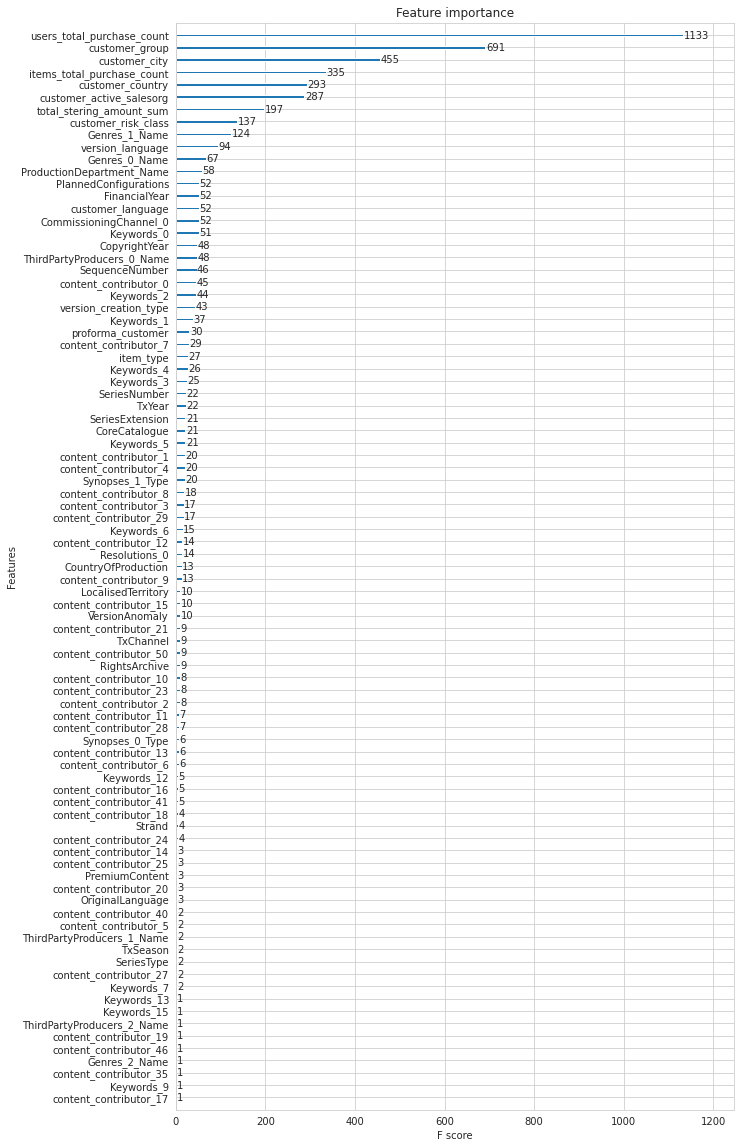

Train confusion_matrix


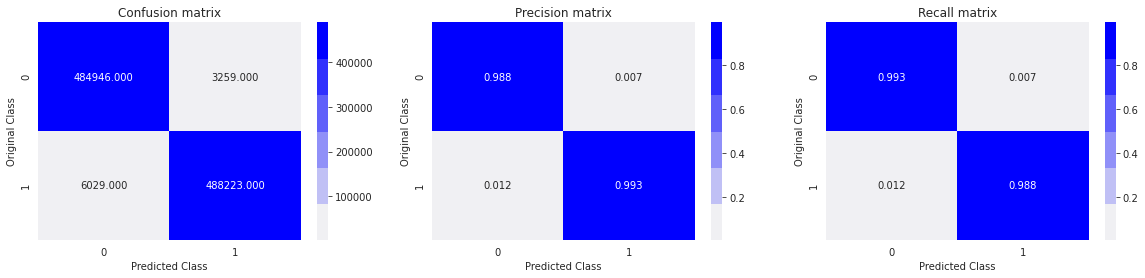

Test confusion_matrix


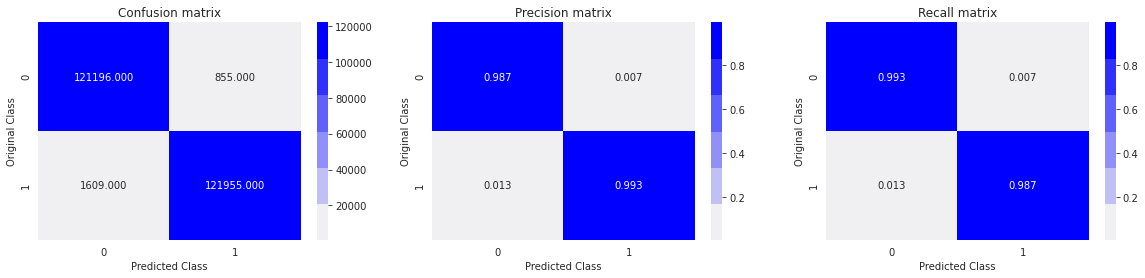

In [14]:
def model_training_pipeline(version_number):
  train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

  train_data = pd.read_csv(drive_path+"/intermittent_saved_files/train_data.csv", dtype=train_test_df_dtypes)
  test_data = pd.read_csv(drive_path+"/intermittent_saved_files/test_data.csv", dtype=train_test_df_dtypes)


  print('prepare Train data & prepare CV data')
  x_train = train_data.drop(['user_id','item_id','class_label'], axis=1)
  y_train = train_data['class_label']

  print('Prepare Test data')
  x_test = test_data.drop(['user_id','item_id', 'class_label'], axis=1)
  y_test = test_data['class_label']

  print(x_train.shape, x_test.shape)

  print('Model training......')
  xgb_clf = XGBClassifier(n_estimators=800)
  xgb_clf.fit(x_train, y_train)
  print('Done')

  filename = '/production_data/xgb_clf_{0}.model'.format(version_number)

  print('save the model')
  xgb_clf.save_model(drive_path+filename)

  y_train_pred = xgb_clf.predict(x_train)
  y_test_pred = xgb_clf.predict(x_test)

  print('save y_train, y_test, y_train_pred, y_test_pred') 
  pd.to_pickle(y_train, drive_path+'/production_data/y_train.pkl')
  pd.to_pickle(y_test, drive_path+'/production_data/y_test.pkl')

  pd.to_pickle(y_train_pred, drive_path+'/production_data/y_train_pred.pkl')
  pd.to_pickle(y_test_pred, drive_path+'/production_data/y_test_pred.pkl')

  print('Train f1 score',f1_score(y_train,y_train_pred))
  print('Test f1 score',f1_score(y_test,y_test_pred))

  %matplotlib inline
  fig, ax = plt.subplots(figsize=(10, 20))
  xgb.plot_importance(xgb_clf, ax=ax)
  plt.show()

  def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
  
  print('Train confusion_matrix')
  plot_confusion_matrix(y_train,y_train_pred)
  print('Test confusion_matrix')
  plot_confusion_matrix(y_test,y_test_pred)

model_training_pipeline(1.4)

# Collabrative-Filtering Data and Training Pipeline

In [19]:
def collabrative_filtering_data_and_training_pipeline():
    train_test_df_dtypes = pd.read_pickle(drive_path+'/production_data/train_test_df_dtypes.pkl')

    train_data = pd.read_csv(drive_path+"/intermittent_saved_files/train_data.csv", dtype=train_test_df_dtypes)
    test_data = pd.read_csv(drive_path+"/intermittent_saved_files/test_data.csv", dtype=train_test_df_dtypes)
    all_seriesCollections_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_seriesCollections_with_series_data.csv", dtype=train_test_df_dtypes)
    all_episodeVersions_with_series_data = pd.read_csv(drive_path+"/intermittent_saved_files/all_episodeVersions_with_series_data.csv", dtype=train_test_df_dtypes)


    print('Concetenate two dataframes train and test')
    production_data = pd.concat([train_data[train_data.class_label==1], test_data[test_data.class_label==1]],axis=0)
    print(production_data.shape)
    production_data.head()

    production_columns = list(production_data.columns)
    production_columns.remove('class_label')

    pd.to_pickle(production_columns, drive_path+'/production_data/production_columns.pkl')

    print('save "user_item_class_label_data" to csv file')
    production_data[['user_id', 'item_id', 'items_total_purchase_count', 'version_language', 'OriginalLanguage', 'Genres_0_Name',	'Genres_1_Name', 'customer_country', 'customer_group', 'customer_language', 'class_label']].to_csv(drive_path+'/production_data/user_item_class_label_data.csv',index=False)

    print('load the saved "user_item_class_label_data" file for further processing')
    user_item_class_label_data = pd.read_csv(drive_path+'/production_data/user_item_class_label_data.csv')
    print(user_item_class_label_data.shape)

    print('SeriesCollection to Title Mapping')
    seriesCollection = pd.read_csv(drive_path+'/raw_data/seriesCollection.csv', sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
    seriesCollection.dropna(inplace=True)
    seriesCollection.RecordID = seriesCollection.RecordID.astype(int)
    seriesCollection_to_title_map = {i[0]:i[1] for i in seriesCollection.values}

    print('save seriesCollection_to_title_map')
    pd.to_pickle(seriesCollection_to_title_map, drive_path+'/production_data/seriesCollection_to_title_map.pkl')

    print('EpisodeVersion to Title Mapping')
    episodeVersion = pd.read_csv(drive_path+'/raw_data/episodeVersion.csv', sep=',', encoding='ISO-8859-1', usecols=['RecordID','Display Name'])
    episodeVersion.dropna(inplace=True)
    episodeVersion.RecordID = episodeVersion.RecordID.astype(int)
    episodeVersion_to_title_map = {i[0]:i[1] for i in episodeVersion.values}
    
    print('save episodeVersion_to_title_map')
    pd.to_pickle(episodeVersion_to_title_map, drive_path+'/production_data/episodeVersion_to_title_map.pkl')

    print('Version_Language to Encode Value Mapping')
    version_creation_type_language = pd.read_csv(drive_path+'/raw_data/version_creation_type_language.csv')
    ver_df = version_creation_type_language[['_id', 'version_language']].merge(user_item_class_label_data[['item_id', 'version_language']], left_on='_id', right_on='item_id')
    ver_lang_to_encode_map = {ver_lang:encode_value for (ver_lang, encode_value) in set(zip(ver_df.version_language_x.values, ver_df.version_language_y.values))}
    ver_lang_to_encode_map['<unknown>'] = len(ver_lang_to_encode_map)+1
    pd.to_pickle(ver_lang_to_encode_map, drive_path+'/production_data/ver_lang_to_encode_map.pkl')
    encode_value_to_ver_lang_map = {encode: ver_lang for ver_lang, encode in ver_lang_to_encode_map.items()} 


    print('User to Name Mapping')
    customer_df = pd.read_csv(drive_path+'/raw_data/customer_data.csv', sep=',', encoding='ISO-8859-1')
    cust_df = customer_df.merge(user_item_class_label_data, on='user_id')
    customer_to_name_map = {user_id:user_name for (user_id, user_name) in set(zip(cust_df.user_id, cust_df.contact_name))}
    pd.to_pickle(customer_to_name_map, drive_path+'/production_data/customer_to_name_map.pkl')

    print('Customer Language to Encoded Value Mapping')
    customer_language_to_encode_value_map = {customer_language:encode_value for (customer_language, encode_value) in set(zip(cust_df.customer_language_x.values, cust_df.customer_language_y.values))}
    pd.to_pickle(customer_language_to_encode_value_map, drive_path+'/production_data/customer_language_to_encode_value_map.pkl')
    encode_value_to_customer_language_map = {encode:lang for lang, encode in customer_language_to_encode_value_map.items()}


    print('Country to Encoded Value Mapping')
    country_to_encoded_value_map = {country: encoded_value for (country, encoded_value) in set(zip(cust_df.customer_country_x.values, cust_df.customer_country_y.values))}
    
    print('save country_to_encoded_value_map')
    pd.to_pickle(country_to_encoded_value_map, drive_path+'/production_data/country_to_encoded_value_map.pkl')
    encode_value_to_country_map = {encode:country for country, encode in country_to_encoded_value_map.items()}

    print('Genre to Encoded Value Mapping')
    all_deals_with_series_id = pd.read_csv(drive_path+'/intermittent_saved_files/all_deals_with_series_id.csv', usecols=['item_id','series_id'])
    rl_series_data = pd.read_csv(drive_path+'/intermittent_saved_files/rl_series_data.csv', usecols=['_id', 'Genres_0_Name','Genres_1_Name']) 
    gc = all_deals_with_series_id.merge(rl_series_data, left_on='series_id', right_on='_id').merge(user_item_class_label_data[['item_id','Genres_0_Name','Genres_1_Name']], on='item_id')
    genre_to_encoded_value_map = {genre:encoded_value for (genre, encoded_value) in set(zip(gc['Genres_0_Name_x'].values, gc['Genres_0_Name_y'].values))}
    
    print('save genre_to_encoded_value_map')
    pd.to_pickle(genre_to_encoded_value_map, drive_path+'/production_data/genre_to_encoded_value_map.pkl')
    sub_genre_to_encoded_value_map = {sub_genre:encoded_value for (sub_genre, encoded_value) in set(zip(gc['Genres_1_Name_x'].values, gc['Genres_1_Name_y'].values))}
    
    print('save sub_genre_to_encoded_value_map')
    pd.to_pickle(sub_genre_to_encoded_value_map, drive_path+'/production_data/sub_genre_to_encoded_value_map.pkl')

    print('Content Type to Encoded Value Mapping')
    item_type_to_encoded_value_map = {'Episode Version': 0, 'Format': 1, 'Series Collection': 2}
    
    print('save item_type_to_encoded_value_map')
    pd.to_pickle(item_type_to_encoded_value_map, drive_path+'/production_data/item_type_to_encoded_value_map.pkl')

    print('User Lookup Data')
    user_features = ['user_id', 'users_total_purchase_count', 'customer_group', 'customer_city', 'customer_country', 'customer_active_salesorg', 'proforma_customer', 'customer_language', 'customer_risk_class']
    user_lookup_data = production_data.copy()[user_features]
    print('Before dropping duplicates: ', user_lookup_data.shape)
    user_lookup_data.drop_duplicates(inplace=True)
    print('After dropping duplicates: ', user_lookup_data.shape)
    
    print('save "user_lookup_data" to csv file')
    user_lookup_data.to_csv(drive_path+'/production_data/user_lookup_data.csv',index=False)
    print('reduce the memory size of user_lookup_data')
    user_lookup_data, _ = reduce_mem_usage(user_lookup_data)
    print('save "user_lookup_data" dtypes to pkl file')
    pd.to_pickle(get_dtypes(user_lookup_data),drive_path+'/production_data/user_lookup_data_dtypes.pkl')

    print('Item Lookup Data')
    item_lookup_data = production_data.copy().drop(user_features+['total_stering_amount_sum', 'class_label'],axis=1)
    print('Before dropping duplicates: ', item_lookup_data.shape)
    item_lookup_data.drop_duplicates(inplace=True)
    print('After dropping duplicates: ', item_lookup_data.shape)
    item_lookup_data.head()
    print('save "item_lookup_data" to csv file')
    item_lookup_data.to_csv(drive_path+'/production_data/item_lookup_data.csv',index=False)
    print('reduce the memory size of item_lookup_data')
    item_lookup_data, _ = reduce_mem_usage(item_lookup_data)
    print('save "item_lookup_data" dtypes to pkl file')
    pd.to_pickle(get_dtypes(item_lookup_data),drive_path+'/production_data/item_lookup_data_dtypes.pkl')

    print("SeriesCollection Lookup Data")
    all_seriesCollections_with_series_data = all_seriesCollections_with_series_data[all_seriesCollections_with_series_data.item_id.isin(seriesCollection_to_title_map.keys())]
    print(all_seriesCollections_with_series_data.shape)
    print('save "all_seriesCollections_with_series_data" to csv file')
    all_seriesCollections_with_series_data.to_csv(drive_path+'/production_data/all_seriesCollections_with_series_data.csv',index=False)

    print("EpisodeVersion Lookup Data")
    all_episodeVersions_with_series_data = all_episodeVersions_with_series_data[all_episodeVersions_with_series_data.item_id.isin(episodeVersion_to_title_map.keys())]
    print(all_episodeVersions_with_series_data.shape)
    print('save "all_episodeVersions_with_series_data" to csv file')
    all_episodeVersions_with_series_data.to_csv(drive_path+'/production_data/all_episodeVersions_with_series_data.csv',index=False)

    print('load the saved "user_item_class_label_data" file for further processing')
    user_item_class_label_data = pd.read_csv(drive_path+'/production_data/user_item_class_label_data.csv')

    print('Creating sparse matrix for seriesCollection & episodeVersion')
    user_item_interaction_sparse_matrix = create_user_item_interaction_sparse_matrix(seriesCollection_to_title_map, episodeVersion_to_title_map, user_item_class_label_data)
    print('save "user_item_interaction_sparse_matrix" to pkl file')
    pd.to_pickle(user_item_interaction_sparse_matrix, drive_path+"/production_data/user_item_interaction_sparse_matrix.pkl")

    print('Compute User-User Similarity matrix')
    user_genre_contributor_interaction_sparse_matrix = pd.read_pickle(drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')
    c_c_sim_sparse = create_c_c_sim_sparse(user_genre_contributor_interaction_sparse_matrix)

    print('load user_index_map')
    user_index_map = pd.read_pickle(drive_path+'/production_data/user_index_map.pkl')
    index_user_map = {idx: user for user, idx in user_index_map.items()}

    print('load contrib_index_map')
    contrib_index_map = pd.read_pickle(drive_path+'/production_data/contrib_index_map.pkl')
    index_contrib_map = {idx: contrib for contrib, idx in contrib_index_map.items()}

    print('load user_contributor_interaction_sparse_matrix')
    user_contributor_interaction_sparse_matrix = pd.read_pickle(drive_path+'/production_data/user_genre_contributor_interaction_sparse_matrix.pkl')

    print('Concetenate two dataframes train and test')
    production_data = pd.concat([train_data[train_data.class_label==1], test_data[test_data.class_label==1]],axis=0)
    print(production_data.shape)

    top_users_per_genre_and_contrib, top_simillar_users_per_genre_and_contrib = recommend_new_item_to_users(index_user_map, index_contrib_map, user_contributor_interaction_sparse_matrix, production_data, c_c_sim_sparse, contrib_index_map, top_users = 10)

    print('save top_users_per_genre & top_simillar_users_per_genre files')
    pd.to_pickle(top_users_per_genre_and_contrib, drive_path+'/production_data/top_users_per_genre_and_contrib.pkl')
    pd.to_pickle(top_simillar_users_per_genre_and_contrib, drive_path+'/production_data/top_simillar_users_per_genre_and_contrib.pkl')

    print('SeriesCollection-SeriesCollection Similarity matrix')
    sc_sc_sim_sparse = create_sc_sc_sim_sparse(user_item_interaction_sparse_matrix)

    print('EpisodeVersion-EpisodeVersion Similarity matrix')
    epv_epv_sim_sparse = create_epv_epv_sim_sparse(user_item_interaction_sparse_matrix)

    print('Create recommendation function for new User')
    #user_country_genre_category_wise_items = { i: production_data[production_data.customer_country==i]['item_id'].value_counts().index for i in production_data['customer_country'].unique()}

    user_country_genre_category_wise_items = {}

    for country in country_to_encoded_value_map.keys():
      user_country_genre_category_wise_items[country] = {}
      for content, data in {'Series Collection': seriesCollection_to_title_map, 'Episode Version': episodeVersion_to_title_map}.items():
        ids = [id for id in user_item_class_label_data.item_id.unique() if id in data.keys()]
        data0 = user_item_class_label_data[user_item_class_label_data.item_id.isin(ids)]
        user_country_genre_category_wise_items[country][content] = {}
        for genre in genre_to_encoded_value_map.keys():
          cond1 = data0.customer_country==country_to_encoded_value_map[country]
          cond2 = data0['Genres_0_Name']==genre_to_encoded_value_map[genre]
          user_country_genre_category_wise_items[country][content][genre]=data0[cond1 & cond2]['item_id'].value_counts().index

      sc_to_index_map = {sc: idx for idx, sc in enumerate(seriesCollection_to_title_map.keys())}
      index_to_sc_map = {idx: sc for sc, idx in sc_to_index_map.items()}

      epv_to_index_map = {epv: idx for idx, epv in enumerate(episodeVersion_to_title_map.keys())}
      index_to_epv_map = {idx: epv for epv, idx in epv_to_index_map.items()}

    top_items_per_user_country_genre_category, top_simillar_items_per_user_country_genre_category = recommendatation_for_new_user(user_country_genre_category_wise_items, sc_sc_sim_sparse, sc_to_index_map, index_to_sc_map, epv_epv_sim_sparse, epv_to_index_map, index_to_epv_map, top_users=10)

    print('save top_items_per_user_country_genre_category & top_simillar_items_per_user_country_genre_category files')
    pd.to_pickle(top_items_per_user_country_genre_category, drive_path+'/production_data/top_items_per_user_country_genre_category.pkl')
    pd.to_pickle(top_simillar_items_per_user_country_genre_category, drive_path+'/production_data/top_simillar_items_per_user_country_genre_category.pkl')

collabrative_filtering_data_and_training_pipeline()

Concetenate two dataframes train and test
(617816, 133)
save "user_item_class_label_data" to csv file
load the saved "user_item_class_label_data" file for further processing
(617816, 11)
SeriesCollection to Title Mapping
save seriesCollection_to_title_map
EpisodeVersion to Title Mapping
save episodeVersion_to_title_map
Version_Language to Encode Value Mapping
User to Name Mapping
Customer Language to Encoded Value Mapping
Country to Encoded Value Mapping
save country_to_encoded_value_map
Genre to Encoded Value Mapping
save genre_to_encoded_value_map
save sub_genre_to_encoded_value_map
Content Type to Encoded Value Mapping
save item_type_to_encoded_value_map
User Lookup Data
Before dropping duplicates:  (617816, 9)
After dropping duplicates:  (1497, 9)
save "user_lookup_data" to csv file
reduce the memory size of user_lookup_data
Memory usage of properties dataframe is : 0.035691261291503906  MB
******************************
Column:  user_id
dtype before:  uint32
dtype after:  uint32
*

100%|██████████| 602843/602843 [48:58<00:00, 205.19it/s]


save "user_item_interaction_sparse_matrix" to pkl file
Compute User-User Similarity matrix
Done..
Saving it to disk without the need of re-computing it again.. 
It's a  (18326, 18326)  dimensional matrix
0:00:07.249786
load user_index_map
load contrib_index_map
load user_contributor_interaction_sparse_matrix
Concetenate two dataframes train and test
(617816, 133)


100%|██████████| 18326/18326 [18:52<00:00, 16.19it/s]


save top_users_per_genre & top_simillar_users_per_genre files
SeriesCollection-SeriesCollection Similarity matrix
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (28578, 28578)  dimensional matrix
0:00:00.037740
EpisodeVersion-EpisodeVersion Similarity matrix
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (153264, 153264)  dimensional matrix
0:00:15.858750
Create recommendation function for new User


100%|██████████| 92/92 [00:39<00:00,  2.31it/s]


save top_items_per_user_country_genre_category & top_simillar_items_per_user_country_genre_category files


In [ ]:
content_based_data_pipleline()
model_training_pipeline(version_number)
collabrative_filtering_data_and_training_pipeline()